<a href="https://colab.research.google.com/github/pgupta7/Cycle_GAN_For_MonetConversion/blob/main/Cycle_GAN_for_MonetConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color = 'blue'>
In this project, we will convert photographic images to Monet-esque images. As dataset, we have 300 Monet style images and a little over 7000 photographic images. Our job in this project is to learn the features of 300 Monet images and apply them to the photographic images.<br><br>
This kind of task is best handled by a neural network based algorithm, known as cycle generative adversarial network, aka cycle-GAN.<br><br>
Cycle GAN itself is similar in principle to a regular GAN but with some modifications.<br>
In this algorithm, we use two generators called G and F, and two discriminators called D<sub>x</sub> and D<sub>y</sub>. Let's say Y is the set of images whose features we want to apply to another set of images called X. The algorithm does the following steps:
<ul>
<li><font color = 'blue'>Generator G learns to transform image X to image Y</li>
<li>Generator F learns to transform image Y to image X</li>
<li>Discriminator D<sub>x</sub> learns to discriminate between X and the generated image of X, i.e., F(Y).</li>
<li>Discriminator D<sub>y</sub> learns to discriminate between Y and the generated image of Y, i.e., G(X).</li>
</ul><br>
We use optimizers for the two generators and the deiscriminator, which compute the respective losses for each of them, and finally compute the gradient and apply them to compute the weights for each of the neural network.<br><br>
To develop the algorithm for cycle GAN, I have taken help from the following tensorflow tutorial: <a>https://www.tensorflow.org/tutorials/generative/cyclegan</a>.<br><br>
The cycleGAN method is an extension to the conditional GAN, aka pix2pix method, mentioned in the following link <a>https://www.tensorflow.org/tutorials/generative/pix2pix</a>, also explained in the following original paper: <a>https://arxiv.org/abs/1611.07004</a>.

## Data download and libraries

<font color = 'blue'>
In the below cell, I download the data from the associated Kaggle competition.

In [ ]:
import kagglehub
gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')

100%|██████████| 367M/367M [00:14<00:00, 26.1MB/s]

Extracting files...


Data source import complete.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
gan_getting_started_path

'/root/.cache/kagglehub/competitions/gan-getting-started'

In [ ]:
os.listdir('/content')

['.config', 'sample_data']

In [ ]:
#listing the folders in the root directory
os.listdir(gan_getting_started_path)

['monet_tfrec', 'monet_jpg', 'photo_jpg', 'photo_tfrec']

In [ ]:
# loading the names of Monet image files
monet_files = os.listdir(os.path.join(gan_getting_started_path, 'monet_jpg'))
len(monet_files)

300

<font color = 'blue'>
Loading the names of the photographic image files. We will transform them to monet style.

In [ ]:
# loading the names of the photographic image files.
photo_files = os.listdir(os.path.join(gan_getting_started_path, 'photo_jpg'))
len(photo_files)

7038

In [ ]:
# Helper function to load the images
def load_image(image_path):
  image_path = os.path.join(image_path)
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  return image

<font color = 'blue'>
To train the cycle GAN algorithm, we will use only 300 of the over 7000 available phtographic images, which is equal to the number of Monet images avaiable. <br>
However, we are not conceptually limited to use equal number of photographic and Monet images. We can use more photographic images to train the neural networks, but it increases the running time. To keep the running time within reasonable limits, I chose to pair a photographic image with a unique Monet image while training the neural nets.

In [ ]:
#loading the images from the filenames
monet_train_images = [load_image(os.path.join(gan_getting_started_path, 'monet_jpg', i)) for i in monet_files]
photo_train_images = [load_image(os.path.join(gan_getting_started_path, 'photo_jpg', i)) for i in photo_files[:300]]

In [ ]:
# loading 10 photograhic images to test the algorithm after training.
photo_images = [load_image(os.path.join(gan_getting_started_path, 'photo_jpg', i)) for i in photo_files[310:320]]

<font color = 'blue'>
Next, I will convert the data to the tensor dataset format, which is more effiecient in neural net training than numpy arrays.

In [ ]:
monet_train_images = tf.data.Dataset.from_tensor_slices(monet_train_images)
photo_train_images = tf.data.Dataset.from_tensor_slices(photo_train_images)
photo_images = tf.data.Dataset.from_tensor_slices(photo_images)

<font color = 'blue'>
Before moving forward, we will visually assess the differences between a Monet and a photographic image.

Monet images


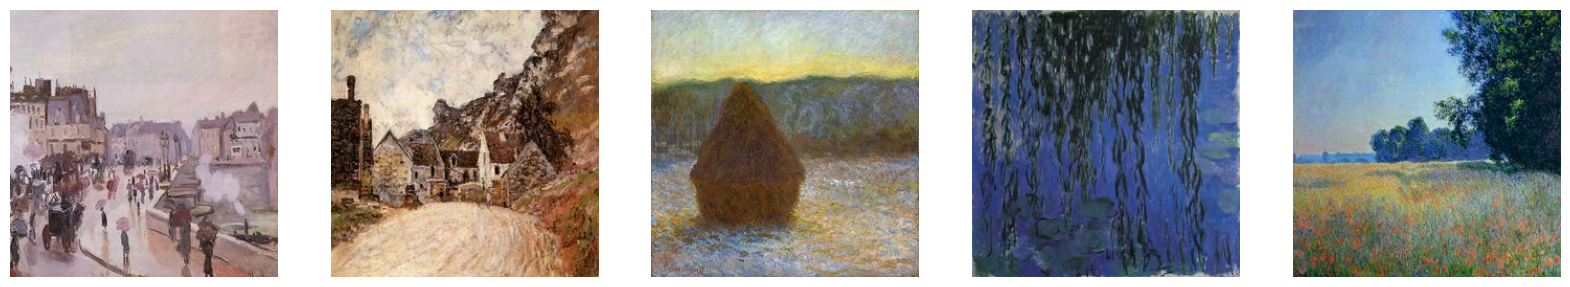

In [ ]:
# plotting first five images from monet_train_images

import matplotlib.pyplot as plt
def view_image(dataset):
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))
  for i, image in enumerate(dataset.take(5)):
      axes[i].imshow(image)
      axes[i].axis('off')
  plt.show()

print('Monet images')
view_image(monet_train_images)

Photographic images


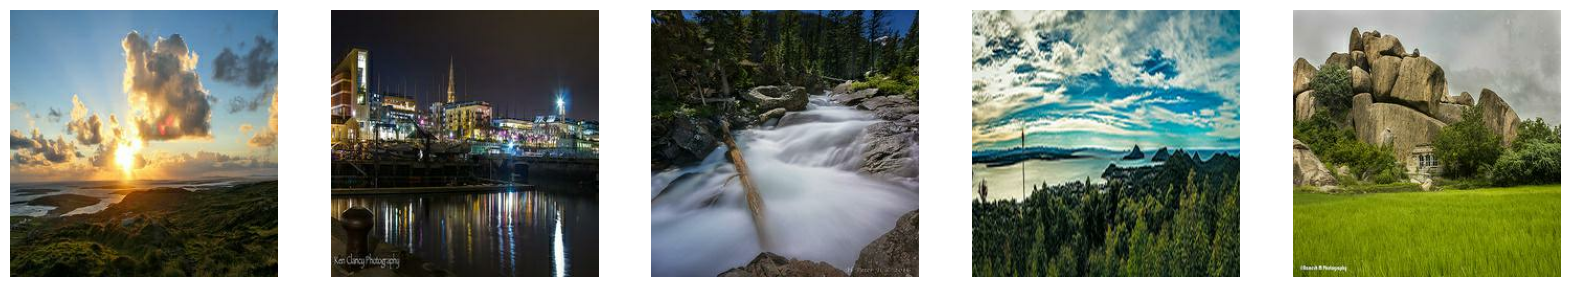

In [ ]:
print('Photographic images')
view_image(photo_train_images)

## Data preprocessing

<font color = 'blue'>
Next we apply random jittering and mirroring to the training datasets. These technique helps avoid overfitting.

In [ ]:
# Setting the useful constants for later use.
BUFFER_SIZE = 300
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

<font color = 'blue'>
Creating the training and the test datasets

In [ ]:
# Training datset
monet_train_images = monet_train_images.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
photo_train_images = photo_train_images.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

# Test datset
photo_images = photo_images.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

## Neural Nets for the generators and discriminators

<font color = 'blue'>
Our generators G and F have to convert from Monet to photographi image, and vice versa, respectively. Hence, we will use a generator model that takes a 256 X 256 X 3 input image and outputs a same size image 256 X 256 X 3.<br>
In between, we will use various tensorflow layers to extract information from the input image and transfer it into an output image.

In [ ]:
initializer = tf.random_normal_initializer(0., 0.02)
def make_generator():
  generator = tf.keras.Sequential([
      tf.keras.layers.Input(shape = [256, 256, 3]),
      tf.keras.layers.Conv2D(64, 4, strides = 2, padding = 'same',kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5), # Drop out to avoid overfitting
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.3),
      tf.keras.layers.Conv2D(128, 4, strides = 2, padding = 'same', kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.3),
      tf.keras.layers.Conv2D(256, 4, strides = 2, padding = 'same', kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.3),
      tf.keras.layers.Conv2DTranspose(32, 4, strides = 2, padding = 'same', kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.3),
      tf.keras.layers.Conv2DTranspose(16, 4, strides = 2, padding = 'same', kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.3),
      tf.keras.layers.Conv2DTranspose(3, 4, strides = 2, padding = 'same', activation = 'tanh', kernel_initializer= initializer, use_bias = False),
  ])
  return generator

# We use the same neural net architecture for both the generators.
generator_g = make_generator()
generator_f = make_generator()

In [ ]:
# We use various convolution layers to bring the discrimator to a size of 900 nodes and we use these 900 nodes from a real and a
# fake image to compute the loss function.
def make_discriminator():
  generator = tf.keras.Sequential([
      tf.keras.layers.Input(shape = [256, 256, 3]),
      tf.keras.layers.Conv2D(64, 4, strides = 2, padding = 'same', activation = 'relu',kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(128, 4, strides = 2, padding = 'same', activation = 'relu',kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(256, 4, strides = 2, padding = 'same', activation = 'relu',kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(1, 3, activation = 'relu', padding= 'valid',kernel_initializer= initializer, use_bias = False),
      tf.keras.layers.Flatten()
  ])
  return generator

# We use the same neural net architecture for both the discriminators.
discriminator_x = make_discriminator()
# discriminator_x.summary()
discriminator_y = make_discriminator()
# discriminator_y.summary()

In [ ]:
discriminator_x.summary()

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_280 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_281 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_282 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_282 (Dropout)           │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_283 (Conv2D)             │ (None, 30, 30, 1)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 900)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,736 (2.52 MB)

 Trainable params: 660,736 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

<font color = 'blue'>
Next, we will check out the architecture of the generators and the discriminators.

In [ ]:
generator_g.summary()

Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_274 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_270 (Dropout)           │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_158 (LeakyReLU)     │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_275 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_271 (Dropout)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_159 (LeakyReLU)     │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_276 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_272 (Dropout)           │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_160 (LeakyReLU)     │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_131            │ (None, 64, 64, 32)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_161 (LeakyReLU)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_132            │ (None, 128, 128, 16)   │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_162 (LeakyReLU)     │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_133            │ (None, 256, 256, 3)    │           768 │
│ (Conv2DTranspose)               │                        │             

 Total params: 800,448 (3.05 MB)

 Trainable params: 799,456 (3.05 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
generator_f.summary()

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_277 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_275 (Dropout)           │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_163 (LeakyReLU)     │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_278 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_276 (Dropout)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_164 (LeakyReLU)     │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_279 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_277 (Dropout)           │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_165 (LeakyReLU)     │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_134            │ (None, 64, 64, 32)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_278 (Dropout)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_166 (LeakyReLU)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_135            │ (None, 128, 128, 16)   │         8,192 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_279 (Dropout)           │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_167 (LeakyReLU)     │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_136            │ (None, 256, 256, 3)    │           768 │
│ (Conv2DTranspose)               │                        │             

 Total params: 800,448 (3.05 MB)

 Trainable params: 799,456 (3.05 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
discriminator_x.summary()

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_280 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_281 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_282 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_282 (Dropout)           │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_283 (Conv2D)             │ (None, 30, 30, 1)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 900)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,736 (2.52 MB)

 Trainable params: 660,736 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator_y.summary()

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_284 (Conv2D)             │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_283 (Dropout)           │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_285 (Conv2D)             │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_284 (Dropout)           │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_286 (Conv2D)             │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_285 (Dropout)           │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_287 (Conv2D)             │ (None, 30, 30, 1)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 900)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,736 (2.52 MB)

 Trainable params: 660,736 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

<font color = 'blue'>
I have referenced following tensorflow tutorial for the cycle GAN algorithm: <a>https://www.tensorflow.org/tutorials/generative/cyclegan</a>.
I will describe below the functions of each of the losses.

<font color = 'blue'>
Declaring the loss fucntion to be used.

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

<font color = 'blue'>
Discriminator losses come from comparing the real images to the real image labels and the fake images to the fake image labels.

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

<font color = 'blue'>
Cycle loss and the identity loss are the additional losses that are part of the cycle-GAN algorithm.<br>
Identity loss compares the original image against the image genrated by the operation of alternate genrator. That is, If Y is a monet image and G is the generator to transform a photo image to a Monet, then identity loss also compares Y and G(Y). The assumption here being that G shouldn't cause much change to a Monet image, as it transforms a photo image to a Monet image. Similarly, identity loss also compares X and F(X), where X is a photo image and F transforms a Monet to a photo image. <br><br>
Additionally, if G transforms a photo image to a Monet and F transforms a Monet to a photo image, then the operation of G followed by F on a photo image should result in the same photo image and vice versa opration of G and F on a monet should result in the same Monet. Cyclic loss compares this original image to the one generated by this aformentioned cyclical operation.<br><br>

In [ ]:
LAMBDA = 10

In [ ]:
# Cycle loss
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
# Identity loss
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)

In [ ]:
EPOCHS = 10

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(8, 8))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# making a sample input to check the behavior of the tarining at various epoch levels.
sample_input = next(iter(photo_images))
# sample_input[0]

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

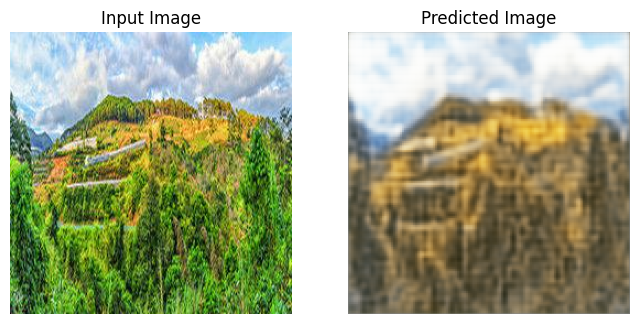

Time taken for epoch 20 is 9.78216004371643 sec



In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((photo_train_images, monet_train_images)):
    # losses.append(train_step(image_x, image_y))
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a sample image to check the progress
  generate_images(generator_g, sample_input)

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

<font color = 'blue'>
Generating data from the trained model by applying it on the test set: photo_images.

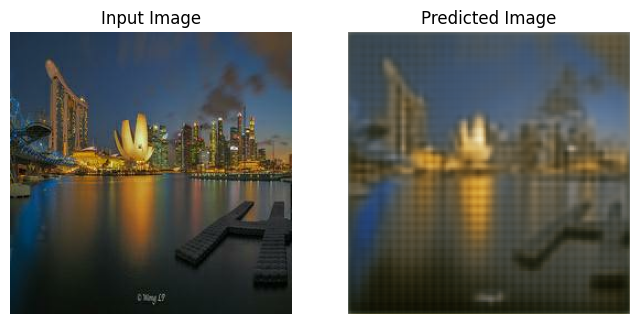

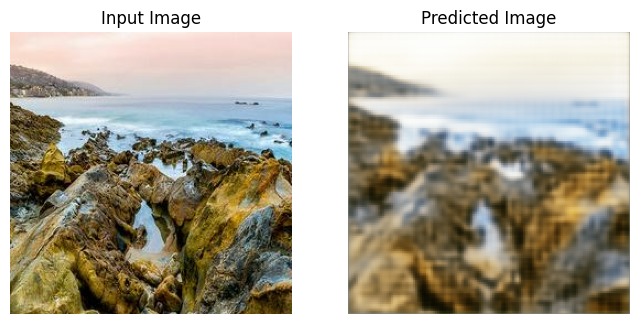

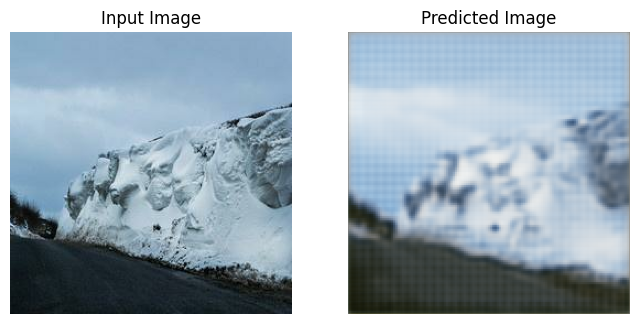

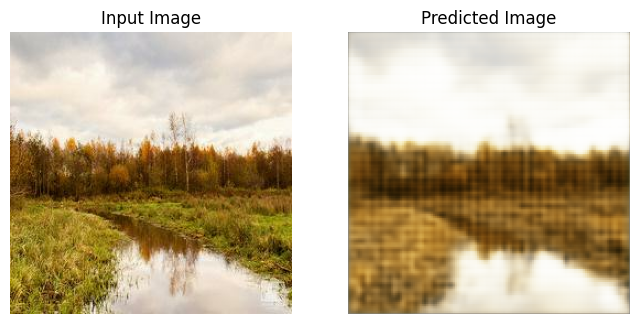

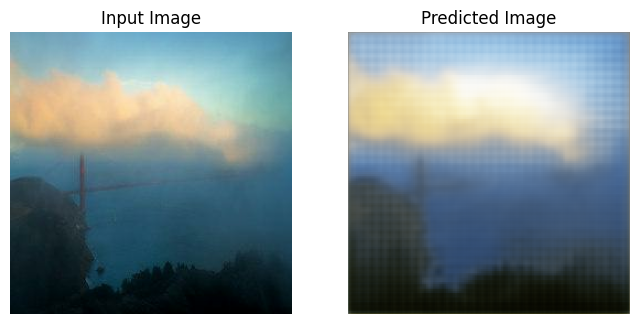

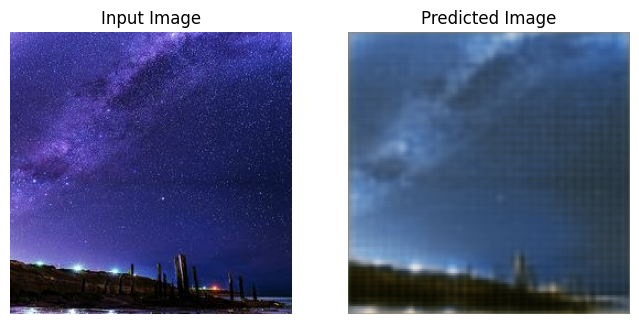

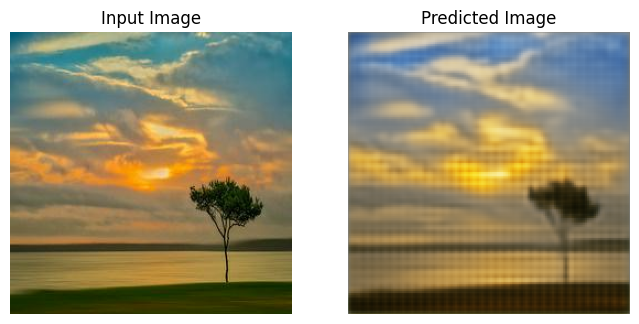

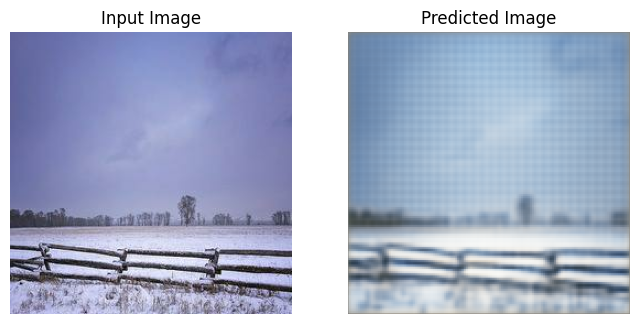

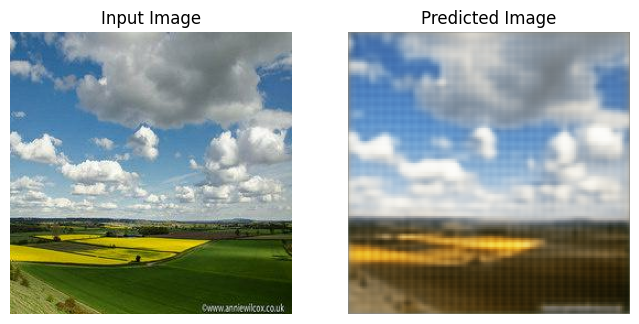

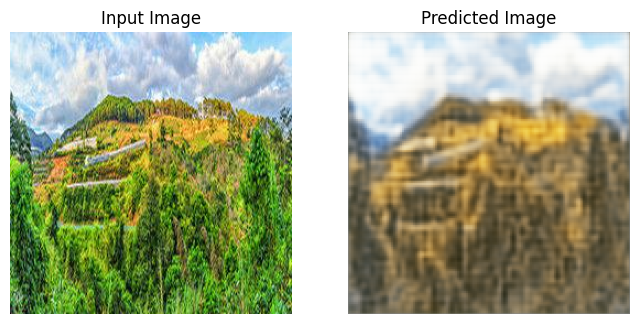

In [ ]:
for ex in photo_images:
  generate_images(generator_g, ex)

<font color = 'blue'>
Next we load all the images in the photo_jpg folder. We will convert these 7000 images to Monet style using our trained cycle GAN.

In [ ]:
photo_test_images = [load_image(os.path.join(gan_getting_started_path, 'photo_jpg', i)) for i in photo_files]

In [ ]:
photo_test_images = tf.data.Dataset.from_tensor_slices(photo_test_images)

In [ ]:
photo_test_images = photo_test_images.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import zipfile
import os
from tqdm import tqdm

# Creating a directory to store the generated images
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)


for i, img in tqdm(enumerate(photo_test_images), leave = True):
    prediction = generator_g(img)
    # Saving the generated image
    generated_image_path = os.path.join(output_dir, f"generated_image_{i}.png")
    plt.imsave(generated_image_path, prediction[0].numpy() * 0.5 + 0.5)

# Creating a zip file containing the generated images and deleting rest of the images from the folder
# leaving only the image.zip file
zip_filename = "generated_images.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
  for root, _, files in os.walk(output_dir):
    for file in files:
      zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))
      os.remove(os.path.join(root, file))


7038it [06:07, 19.14it/s]


<font color = 'blue'>
I submitted the notebook at this point to Kaggle, and it generated the below score, which isn't quite high but seems to do just fine for the project.

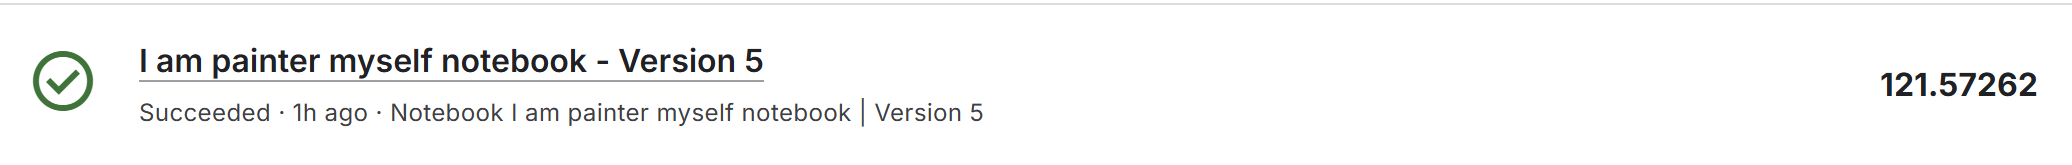

<font color = 'blue'>
Since the score doesn't seem too high on the generators and the discriminators I built, I decided to use another professionally built model, called pix2pix. The generator and the discriminator neural nets were used in a paper on conditional GAN, where the goal was to modify an image condinoned on the characteristics of a given image, an algorithm on which our current cycle GAN is based. <br>
The pix2pix neural net can easily be imported via a tensorflow library, which we do below.

## Model based on pix2pix

<font color = 'blue'>
I ran the algorithm for the cycle GAN using the below generators and discriminators. I have taken these neural nets directly from a tensorflow example model, named pix2pix. It can be directly imported into a python notebook via a tensorflow library.<br> More reference to the model can be found in the following tensorflow tutorials: <a>https://www.tensorflow.org/tutorials/generative/pix2pix</a> and <a>https://www.tensorflow.org/tutorials/generative/cyclegan</a>.<br>
The below neural nets have more layers, meaning more trainable parameters than the model I created above in the notebook. Besides, they use a different normalization technique in their neural nets, called instance normalization, instead of BatchNormalization.<br><br><br>
I have commented out the model, as I had to submit the entire notebook to Kaggle to get the results, so I could keep only one model at a time in the notebook.

In [ ]:
# !pip install git+https://github.com/tensorflow/examples.git

In [ ]:
# from tensorflow_examples.models.pix2pix import pix2pix
# OUTPUT_CHANNELS = 3

# generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm', )
# generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
# discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

<font color = 'blue'>
The pix2pix neural nets produced superior results to the ones I used earlier in the notebook. Below pic shows the result obtained from Kaggle.


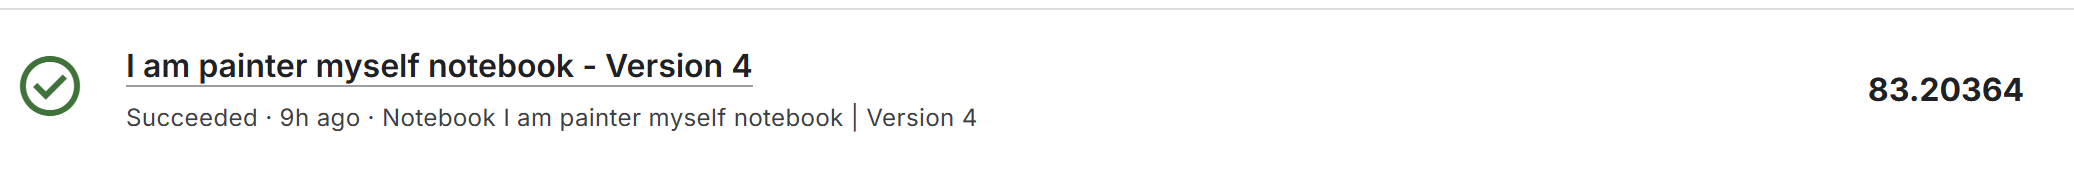

## Conclusion

<font color = 'blue'>
We ran the cycle-GAN algorithm on our dataset, and the algorithm made the photograhic images somewhat Monet-esque. We converted all the 7000+ photo images to Monet style images and submitted them Kaggle, reveiving a score of 121, an OK score. To check the model against a professionally made neural net, I used the generator and discriminator model from the pix2pix architecture as well, and it performed relatively better than the first model we used, diving us a score of 83.
<table>
    <tr>
        <th>Model</th>
        <th>score</th>
    </tr>
    <tr>
        <td>Custom made model</td>
        <td>121.6</td>
    </tr>
    <tr>
        <td>pix2pix neural net architecture</td>
        <td>83.2</td>
    </tr>
</table>
However, there is still significant room for improvment. We can try the following recommendations:<br>
<ul>
<font color = 'blue'>
<li>Make modifications to the generator and the discriminator acrhitecture of pix2pix we used in the project.</li>
<li>Make changes to the learning rates of the optimizers</li>
<li>Train it to higher number of epochs as went only upto 10 epochs.</li>
<li>In the custom model, I used Batch Normalization post every layer, while there are other forms of normalization that could work better in this situation, for reference <a>https://www.tensorflow.org/tutorials/generative/cyclegan</a>.</li>
</ul>